In [1]:
# ==============================
# Core libraries
# ==============================
import os
import warnings
import random
import timeit
import numpy as np
import pandas as pd

# ==============================
# Visualization
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Image processing
# ==============================
import cv2 as cv
from PIL import Image

# ==============================
# Scikit-learn
# ==============================
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ==============================
# TensorFlow / Keras
# ==============================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout, Activation,
    Conv2D, MaxPooling2D, AveragePooling2D,
    GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.xception import Xception

# ==============================
# Callbacks & Optimizers
# ==============================
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping,
    ReduceLROnPlateau, CSVLogger
)

# ==============================
# Utilities
# ==============================
from tqdm import tqdm

# ==============================
# Jupyter
# ==============================
%matplotlib inline


In [15]:
import matplotlib.image as mpimg

In [2]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.


In [3]:
warnings.filterwarnings('ignore')


In [12]:
# Define path to data
annotations_dir = '../Seminar_Project/annotations/Annotation' 
images_dir = '../Seminar_Project/images/Images'

In [25]:
def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array
            img_array = image.img_to_array(dst_img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

In [26]:
import os

all_breed_list = [
    d for d in os.listdir(images_dir)
    if os.path.isdir(os.path.join(images_dir, d))
]


In [28]:
fr_breed_list = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02094433-Yorkshire_terrier',
    'n02085620-Chihuahua',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']

In [29]:
# Define numbers of breeds to preprocess
num_breeds = len(fr_breed_list) 

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(fr_breed_list, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 2522
Shape of images np.array : (2522, 299, 299, 3)
Total time : 1826.25s


In [30]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [31]:
# Change X type 
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)


In [32]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [33]:
# Change X type 
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [34]:
# Verifie encoder created classes
print(encoder.classes_)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [35]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  2017
Test set size =  505


In [36]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

## Xception Model

In [47]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# look at the differents layers
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)

--------------------------------------------------
Xception base model layers :
--------------------------------------------------
<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<BatchNormalization name=block1_conv1_bn, built=True>
<Activation name=block1_conv1_act, built=True>
<Conv2D name=block1_conv2, built=True>
<BatchNormalization name=block1_conv2_bn, built=True>
<Activation name=block1_conv2_act, built=True>
<SeparableConv2D name=block2_sepconv1, built=True>
<BatchNormalization name=block2_sepconv1_bn, built=True>
<Activation name=block2_sepconv2_act, built=True>
<SeparableConv2D name=block2_sepconv2, built=True>
<BatchNormalization name=block2_sepconv2_bn, built=True>
<Conv2D name=conv2d, built=True>
<MaxPooling2D name=block2_pool, built=True>
<BatchNormalization name=batch_normalization, built=True>
<Add name=add, built=True>
<Activation name=block3_sepconv1_act, built=True>
<SeparableConv2D name=block3_sepconv1, built=True>
<BatchNormalizatio

In [48]:
for layer in xception_model.layers:
    layer.trainable = False

In [49]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(num_breeds, activation='softmax')(base_output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [50]:
Xception_plot = plot_model(my_xcept_model,
                           to_file='xcept_model_plot.png',
                           show_shapes=True,
                           show_layer_names=False)
Xception_plot

In [51]:
# Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [53]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) // 32,
    epochs=20,
    verbose=2)

Epoch 1/20
63/63 - 227s - 4s/step - accuracy: 0.6789 - f1_m: 0.6790 - loss: 1.0410 - val_accuracy: 0.7320 - val_f1_m: 0.7300 - val_loss: 0.8508
Epoch 2/20
63/63 - 158s - 3s/step - accuracy: 0.7352 - f1_m: 0.7352 - loss: 0.8377 - val_accuracy: 0.7097 - val_f1_m: 0.6979 - val_loss: 0.8782
Epoch 3/20
63/63 - 219s - 3s/step - accuracy: 0.7346 - f1_m: 0.7343 - loss: 0.8357 - val_accuracy: 0.7320 - val_f1_m: 0.7300 - val_loss: 0.8063
Epoch 4/20
63/63 - 143s - 2s/step - accuracy: 0.7747 - f1_m: 0.7747 - loss: 0.7301 - val_accuracy: 0.7469 - val_f1_m: 0.7548 - val_loss: 0.7082
Epoch 5/20
63/63 - 209s - 3s/step - accuracy: 0.7853 - f1_m: 0.7851 - loss: 0.6754 - val_accuracy: 0.7643 - val_f1_m: 0.7612 - val_loss: 0.7238
Epoch 6/20
63/63 - 156s - 2s/step - accuracy: 0.8109 - f1_m: 0.8109 - loss: 0.5806 - val_accuracy: 0.7568 - val_f1_m: 0.7644 - val_loss: 0.7629
Epoch 7/20
63/63 - 221s - 4s/step - accuracy: 0.7873 - f1_m: 0.7868 - loss: 0.6347 - val_accuracy: 0.7742 - val_f1_m: 0.7708 - val_loss:

In [54]:
my_xcept_model.save("my_xcept_model.keras")
print("Xception model saved successfully!")

Xception model saved successfully!


In [55]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-v0_8-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('Xception model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('Xception model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

In [90]:
for layer in my_xcept_model.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_1
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_2
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_sepco

In [78]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    grad_model = tf.keras.models.my_xcept_model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [89]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image

img_path = (images_dir 
            + "/" 
            + "n02096294-Australian_terrier/n02096294_1803.jpg")

img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [83]:
last_conv_layer_name = "block14_sepconv2_act"

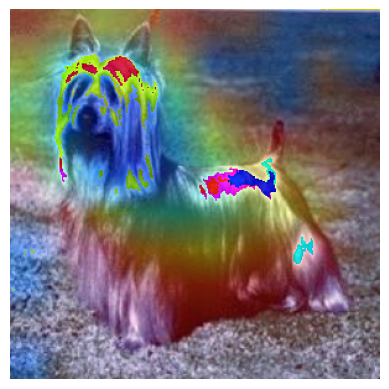

In [91]:
import matplotlib.cm as cm

img = cv2.imread(img_path)
img = cv2.resize(img, (299, 299))

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
jet_heatmap = np.uint8(255 * jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img

plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.show()

In [86]:
# 1️⃣ Get model prediction
preds = my_xcept_model.predict(img_array)

# 2️⃣ Get the predicted class index
class_idx = np.argmax(preds[0])

# 3️⃣ Compute gradients and heatmap
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    loss = preds[:, class_idx]

grads = tape.gradient(loss, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


In [85]:
grad_model = tf.keras.models.Model(
    [my_xcept_model.inputs],
    [my_xcept_model.get_layer(last_conv_layer_name).output, my_xcept_model.output]
)

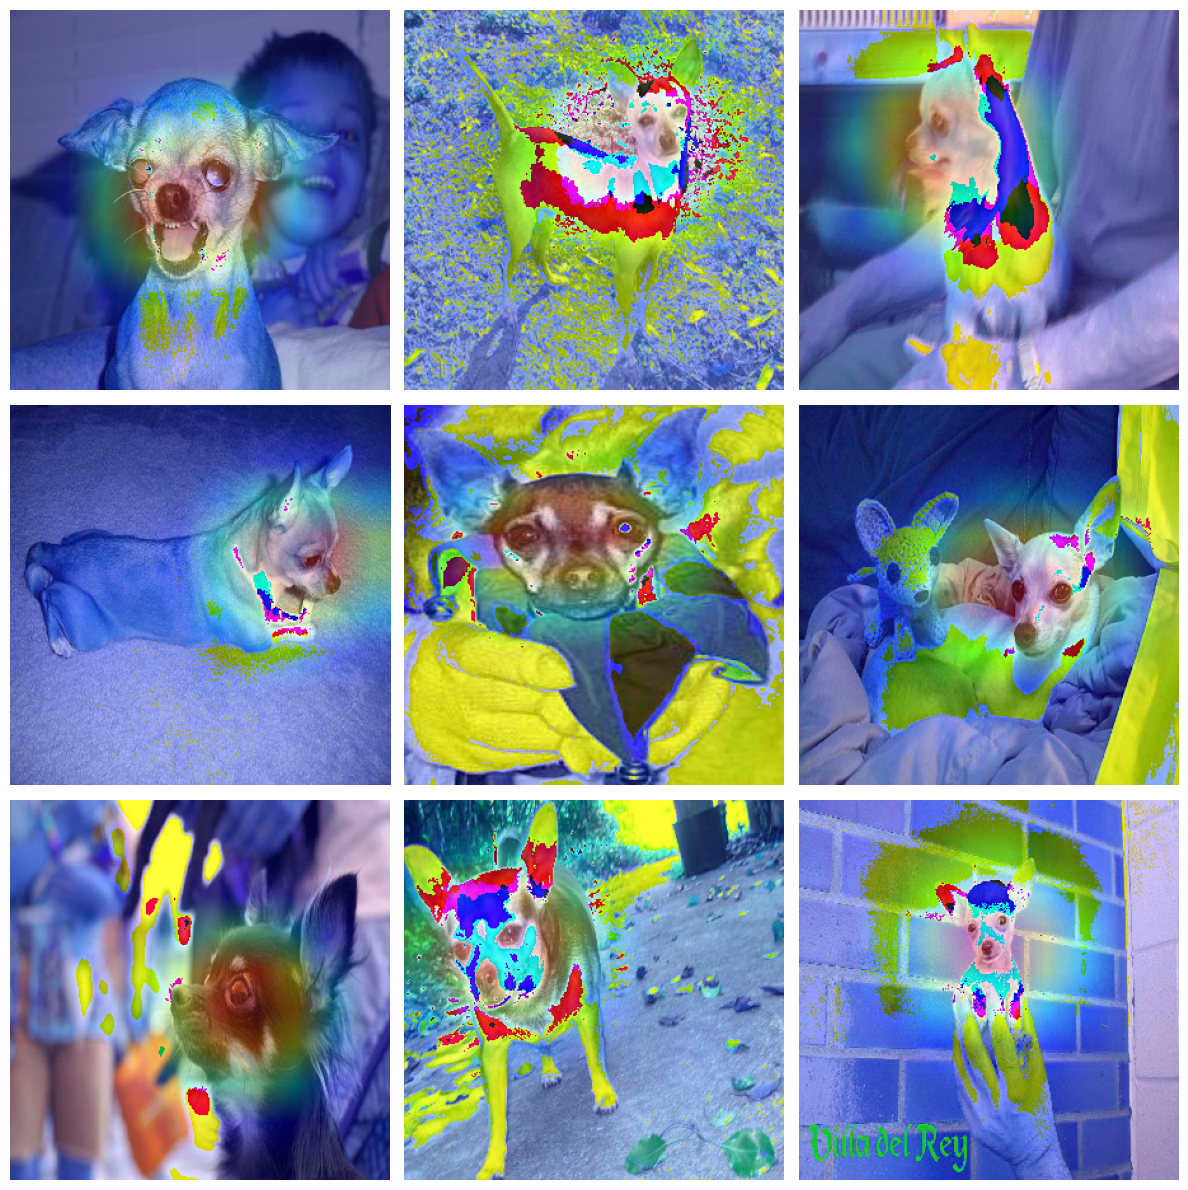

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.cm as cm
import os
import random

plt.figure(figsize=(12,12))

# select 9 random images from a class folder
class_folder = "n02085620-Chihuahua"
class_path = os.path.join(images_dir, class_folder)

image_list = random.sample(os.listdir(class_path), 9)

for i, img_name in enumerate(image_list):

    img_path = os.path.join(class_path, img_name)

    # --- Load image for model ---
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # --- Compute Grad-CAM heatmap ---
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_idx = np.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap = np.uint8(255 * heatmap)

    # --- Superimpose heatmap ---
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (299, 299))

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (299, 299))
    jet_heatmap = np.uint8(255 * jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + original_img

    # --- Plot ---
    plt.subplot(3, 3, i+1)
    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis("off")

plt.tight_layout()
plt.show()